In [ ]:
#|default_exp explore 

# Exploring half a million molecules 

> Zooming into high resolution mass spectrometry data

## Exploring our Nextcloud data 

For our ASAP project research team we created a Nextcloud folder that we can use to easily share our data with [fairdatanow](https://pypi.org/project/fairdatanow/) Python package. Let's take a look what Wim has uploaded so far...   

In [ ]:
from fairdatanow import DataViewer
import os 

In [ ]:
configuration = {
    'url': "https://laboppad.nl/asap-data",
    'user':    os.getenv('NC_AUTH_USER'),
    'password': os.getenv('NC_AUTH_PASS')
}

In [ ]:
dv = DataViewer(configuration)

In [ ]:
dv

DataViewer(bytes_amount=1816076156, columns=['path', 'size', 'modified'], data=                                                   path       size    ext  \
0                                            asap-data/    1.7 GiB          
1                          asap-data/2022-151 Rossetti/  264.4 MiB          
2     asap-data/2022-151 Rossetti/2022-151- MOMS-ASA...    3.6 MiB  .pptx   
3     asap-data/2022-151 Rossetti/2022-151- MOMS-ASA...    3.7 MiB  .pptx   
4     asap-data/2022-151 Rossetti/2022-151- MOMS-ASA...    2.6 MiB  .pptx   
...                                                 ...        ...    ...   
1892                         asap-data/Molform/main.cpp    4.3 KiB   .cpp   
1893                      asap-data/Molform/molform.exe   28.2 KiB   .exe   
1894                         asap-data/a-little-test.md    3 Bytes    .md   
1895                               asap-data/demo-data/   30.7 MiB          
1896      asap-data/demo-data/Ref0443_casein_asap01.RAW   30.7 MiB   .raw   

       byte_size                  modified  isdir  
0     1816076156 2025-11-26 14:48:13+00:00   True  
1      277269735 2025-07-17 09:30:26+00:00   True  
2        3738826 2023-12-05 16:35:16+00:00  False  
3        3887554 2023-12-05 17:28:28+00:00  False  
4        2773236 2023-06-26 17:04:36+00:00  False  
...          ...                       ...    ...  
1892        4381 2025-09-24 11:09:28+00:00  False  
1893       28896 2025-09-24 11:09:45+00:00  False  
1894           3 2025-06-30 14:24:52+00:00  False  
1895    32156788 2025-07-25 11:34:18+00:00   True  
1896    32156788 2023-01-11 14:26:37+00:00  False  

[1897 rows x 6 columns], extensions=[], filtered_data=                                                   path       size  \
2     asap-data/2022-151 Rossetti/2022-151- MOMS-ASA...    3.6 MiB   
3     asap-data/2022-151 Rossetti/2022-151- MOMS-ASA...    3.7 MiB   
4     asap-data/2022-151 Rossetti/2022-151- MOMS-ASA...    2.6 MiB   
6     asap-data/2022-151 Rossetti/KMD plots/000_Temp...    1.5 MiB   
7     asap-data/2022-151 Rossetti/KMD plots/KMDplot_...    3.4 MiB   
...                                                 ...        ...   
1890  asap-data/ASAP atlas of mass spectra and kendr...  876.5 KiB   
1892                         asap-data/Molform/main.cpp    4.3 KiB   
1893                      asap-data/Molform/molform.exe   28.2 KiB   
1894                         asap-data/a-little-test.md    3 Bytes   
1896      asap-data/demo-data/Ref0443_casein_asap01.RAW   30.7 MiB   

                      modified  
2    2023-12-05 16:35:16+00:00  
3    2023-12-05 17:28:28+00:00  
4    2023-06-26 17:04:36+00:00  
6    2023-06-21 09:37:36+00:00  
7    2023-12-05 17:28:10+00:00  
...                        ...  
1890 2025-09-14 13:55:38+00:00  
1892 2025-09-24 11:09:28+00:00  
1893 2025-09-24 11:09:45+00:00  
1894 2025-06-30 14:24:52+00:00  
1896 2023-01-11 14:26:37+00:00  

[1706 rows x 3 columns], name='DataViewer00117', search='', show_directories=False, show_filters=False, use_regex=False)

![fairdatanow](images/screencast-fairdatanow.gif)

For this example we want to download all `.RAW` files present in the folder containing the string `lange` the Nextcloud server to our local computer. As shown in the gif animation above. This can be done by first typing the filename and Enter key in the search bar, and subsequently selecting the `.raw` extension in the filters menu. We can now select all files in the table by clicking on the first row and shift-clicking on the last row. All blue files can be downloaded to your local computer using the method `.download_selected()`

In [ ]:
files = dv.download_selected()

Ready with downloading 2 selected remote files to local cache: /home/frank/.cache/fairdatanow                                                                                                                   


The list of downloaded files on your computer is stored in the `files` variable. Let's take a look at the file paths in our local cache directory. 

In [ ]:
print('(Skipping first 35 items)')
for i, file in enumerate(files): 
    if i > 35:
        print(i, file)

(Skipping first 35 items)
36 /home/frank/.cache/fairdatanow/asap-data/2025 Théo-Fany Lange - the dutch method/xcalibur raw data files/Matt_Joana_100-24-1_01.RAW
37 /home/frank/.cache/fairdatanow/asap-data/2025 Théo-Fany Lange - the dutch method/xcalibur raw data files/Matt_Joana_100-24-2_01.RAW
38 /home/frank/.cache/fairdatanow/asap-data/2025 Théo-Fany Lange - the dutch method/xcalibur raw data files/Matt_Joseba_01.RAW
39 /home/frank/.cache/fairdatanow/asap-data/2025 Théo-Fany Lange - the dutch method/xcalibur raw data files/Matt_Julia_T1_01.RAW
40 /home/frank/.cache/fairdatanow/asap-data/2025 Théo-Fany Lange - the dutch method/xcalibur raw data files/Matt_Julia_T2_01.RAW
41 /home/frank/.cache/fairdatanow/asap-data/2025 Théo-Fany Lange - the dutch method/xcalibur raw data files/Matt_Marina_MFH_A_01.RAW
42 /home/frank/.cache/fairdatanow/asap-data/2025 Théo-Fany Lange - the dutch method/xcalibur raw data files/Matt_Marina_MFH_B_01.RAW
43 /home/frank/.cache/fairdatanow/asap-data/2025 Théo

In order to avoid searching again, it is possible to save the complete search filter settings with the `.export_filters()` method. 

In [ ]:
my_filters = dv.export_filters()
my_filters

{'columns': ['path', 'size', 'modified'],
 'extensions': ['.raw'],
 'search': 'lange',
 'show_directories': False,
 'show_filters': False,
 'use_regex': False}

This dictionary of filters can next time be used to directly obtain the files list like so:  

In [ ]:
dv = DataViewer(configuration, **myfilters)

## Reading our first .raw file

Nice! We are now ready to actually explore the data. First step is to read an .raw file containing (already scan-centroided) ASAP-HRMS data. The data can be loaded into a positive and a  negative mode dataframe as with the `read_raw()` function which returns two dataframes for positive and negative mode. This function is based on the [pyRawTools](https://pypi.org/project/pyRawTools/) python package. Let's take a look at `Matt_Joana_100-24-1_01.RAW`. 

In [ ]:
from kendrick import read_raw

In [ ]:
raw_file = files[36] # 
raw_file

'/home/frank/.cache/fairdatanow/asap-data/2025 Théo-Fany Lange - the dutch method/xcalibur raw data files/Matt_Joana_100-24-1_01.RAW'

In [ ]:
df_pos, df_neg = read_raw(raw_file) 

Let's focus on the positive mode data for now. Here is what the first and last rows of the dataframe looks like. 

In [ ]:
df_pos

,RT,mz,inty
Scan,,,
1,0.00559,91.039505,9.846962e+04
1,0.00559,91.057877,4.731688e+04
1,0.00559,93.037094,1.971464e+05
1,0.00559,93.070290,4.869656e+05
1,0.00559,94.065620,8.750284e+04
...,...,...,...
381,3.00519,607.520447,9.569468e+05
381,3.00519,610.541321,6.589495e+05
381,3.00519,612.554993,1.010656e+06


Inspecting the `df_pos` dataframe we find 151018 rows with a **Scan** number index and three columns: 1) **RT** *retention time*, 2) **mz** *mass per electrical charge*, and 3) **inty** *number of ions*. From the first column one can see that this experiment lasted 3 minutes. 

As we will see, m/z values for identical molecules are slightly jittered due to limited instrumental precision. In order to determine the abundance of different molecules present in the sample, we now need to create time averaged centroided m/z values. This can be achieved by 1) first binning the data in a histogram, 2) then Gaussian smoothing the histogram and locating the peaks. These steps are implemented in the functions `histogram()` and `get_time_averaged_centroids()`. 

Next step is to explore the data in an interactive visualization. In order to plot half a million data points in a single plot we need to import a special function `interactive_plot()`. This function makes heavily use of a powerful python package [datashader](https://datashader.org/) that is designed for fast plotting huge numbers of data points. 

::: {.callout-note}
Note that in order to activate interactive plotting in a Jupyter notebook you need to execute the following notebook magic command in a code cell: 
    %matplotlib widget
:::

In [ ]:
%matplotlib widget

In [ ]:
from kendrick import histogram, get_time_averaged_centroids, interactive_plot 

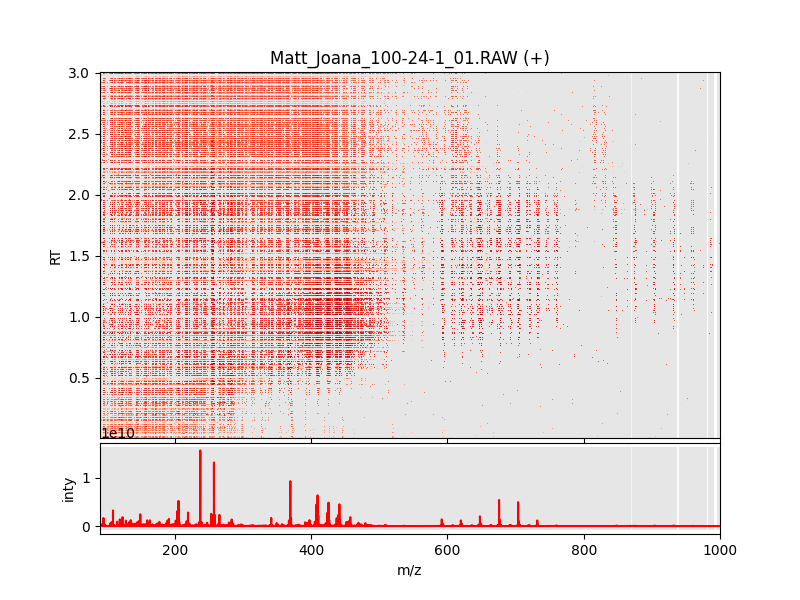

In [ ]:
mz_hist = histogram(df_pos)
mz_centroids = get_time_averaged_centroids(mz_hist)

interactive_plot(df_pos, mz_hist, mz_centroids, title='Matt_Joana_100-24-1_01.RAW (+)')

![](images/screencast-zoom-in2.gif)

## FUNCTIONS 

In [ ]:
#|export 

import pyRawTools as rwt 
import dask.array as da 
import scipy.signal as ssg 
from scipy.ndimage import gaussian_filter 
import numpy as np 

import datashader as ds
import datashader.transfer_functions as tf
from datashader.mpl_ext import dsshow 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

from functools import partial  

In [ ]:
#|export 

def read_raw(raw_file): 
    '''Read `raw_file` into positive and negative mode data frames. '''

    loader = rwt.MSLoader()
    df = loader.load(raw_file) 
    df.columns = ['RT', 'mz', 'inty']
    df_pos = df.iloc[::2]
    df_neg = df.iloc[1::2] 

    return df_pos, df_neg
    

def read_mzml(mzml_file): 
    '''Read `mzml_file`. 
    
    Returns positive and negative mode dataframes `df_pos` and `df_min`. '''

    # load example file
    exp = oms.MSExperiment()
    oms.MzMLFile().load(mzml_file, exp) 
    df_long = exp.get_df(long=True) 

    # split +/- 
    df_pos = df_long.iloc[::2] # positive?
    df_neg = df_long.iloc[1::2] # negative? 

    return df_pos, df_neg 


def histogram(df):
    '''Create intensity weighed histogram. '''

    # create dask arrays 
    x = da.from_array(df['mz'])
    y = da.from_array(df['inty']) 
    
    # make dask histograms 
    #mz_hist, bins = da.histogram(x, bins=10000000, range=[0, 1000]) # simply number of mass points in bin 
    mz_hist_w, bins = da.histogram(x, weights=y, bins=10000000, range=[0, 1000]) # weighed with intensities 
    
    # bin centers for plotting 
    bin_delta = bins[1] - bins[0]
    bin_centers = bins[0:-1] + 0.5 * bin_delta 

    mz_hist_w_xy = np.c_[bin_centers, mz_hist_w]

    return mz_hist_w_xy

def get_time_averaged_centroids(mz_hist_w_xy):
    '''Get peaks (centroids) from histogram. '''
    
    bin_centers, mz_hist_w = mz_hist_w_xy.T 
    
    # gaussian smoothing of weighed histogram 
    mz_hist_w_gauss = gaussian_filter(mz_hist_w, sigma=2)
    
    # find peaks 
    peak_idxs_w_gauss, props_dict_w = ssg.find_peaks(mz_hist_w_gauss, height=4000, distance=50) # bit ad hoc 
    peak_heights_w_gauss = props_dict_w['peak_heights'] 

    mz_x = bin_centers[peak_idxs_w_gauss] 
    mz_y = peak_heights_w_gauss 

    mz_centroids = np.c_[mz_x, mz_y]
    
    return mz_centroids  

def interactive_plot(df, mz_hist, mz_centroids, title=None): 
    '''Create interactive plot for dataframe `df`. '''

    mz_hist_x, mz_hist_y = mz_hist.T
    mz_centroids_x, mz_centroids_y = mz_centroids.T
    
    
    fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, figsize=[8, 6], gridspec_kw={'height_ratios':[4, 1]}, squeeze=True) 
    
    # number histogram 
    #ax0.plot(bin_centers, mz_hist, c='r')
    #ymin, ymax = ax0.get_ylim()
    #ax0.vlines(bin_centers[peak_idxs_w_gauss], ymin=ymin, ymax=ymax, color=[0.9, 0.9, 0.9], zorder=-10) 
    #ax0.set_ylabel('bin count')
    #ax0.set_title('Ref0443_casein_asap01.mzML (+)')
    mz_min = df['mz'].min()
    
    
    # datashader beast (the most complicated single plot command I have ever made)
    glyph = ds.Point('mz', 'RT') 
    dsshow(df, glyph, aggregator=ds.sum('inty'), ax=ax1, x_range=[100, 1000], plot_height=500, 
           plot_width=1000, aspect='auto', cmap=cm.Reds, norm='log',  
           shade_hook=partial(tf.dynspread, threshold=0.7, max_px=7, how='add')) 
    ymin, ymax = ax1.get_ylim()
    ax1.vlines(mz_centroids_x, ymin=ymin, ymax=ymax, color=[0.9, 0.9, 0.9], zorder=-10)
    ax1.set_ylabel('RT')
    if title != None: 
        ax1.set_title(title)
    
    # intensity weighed histogram 
    ax2.plot(mz_hist_x, mz_hist_y, color='r')
    ymin, ymax = ax2.get_ylim()
    ax2.vlines(mz_centroids_x, ymin=ymin, ymax=ymax, color=[0.9, 0.9, 0.9], zorder=-10) 
    ax2.set_ylabel('inty')
    ax2.set_xlabel('m/z')
    ax2.set_xlim([mz_min, 1000])
    
    plt.subplots_adjust(hspace=0.02)